This project is to showcase my skills in classification and regression trees (CARTs), RandomForests, Adaptive Boosting, Gradient Boosting, and tuning hyperparameters. Specifically, this project will use London bike sharing data and I will be predicting new bike rentals per hour after splitting the data into train and test sets. I will train my models on the training set and predict upon the test set. I will also be comparing different methods' effectiveness (individual CART vs. Adaptive Boosting Ensemble vs. Gradient Boosting Ensemble) as well as identifying the most highly predictive feature for each model in determining the target variable 'cnt' (new bike shares count). First things first: I will load the data, perform some exploratory data analysis(EDA)and visualize, and see if any missing data or outliers are present.

In [1]:
import matplotlib.pyplot as plt          #importing some packages
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

london_bikes = pd.read_csv('Datasets/london_merged.csv', index_col='timestamp', parse_dates=True)  #read in the csv
print(london_bikes.head()) #I'll get a preliminary look at the data

                     cnt   t1   t2    hum  wind_speed  weather_code  \
timestamp                                                             
2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

                     is_holiday  is_weekend  season  
timestamp                                            
2015-01-04 00:00:00         0.0         1.0     3.0  
2015-01-04 01:00:00         0.0         1.0     3.0  
2015-01-04 02:00:00         0.0         1.0     3.0  
2015-01-04 03:00:00         0.0         1.0     3.0  
2015-01-04 04:00:00         0.0         1.0     3.0  


First, a description for all the columns:

"t1" - real temperature in C
"t2" - "feels like" temperature in C
"hum" - humidity as percentage
"wind_speed" - wind speed in km/h
"weather_code" - category of the weather
    1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity
    2 = scattered clouds / few clouds
    3 = Broken clouds
    4 = Cloudy
    7 = Rain/ light Rain shower/ Light rain
    10 = rain with thunderstorm
    26 = snowfall
    94 = Freezing Fog
"is_holiday" - bool - 1 if the day is a holiday
"is_weekend" - bool - 1 if the day is weekend
"season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

Now I will look at the data types for each column as well as if any null entries exist.

In [3]:
london_bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
cnt             17414 non-null int64
t1              17414 non-null float64
t2              17414 non-null float64
hum             17414 non-null float64
wind_speed      17414 non-null float64
weather_code    17414 non-null float64
is_holiday      17414 non-null float64
is_weekend      17414 non-null float64
season          17414 non-null float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


What a clean dataset! I will now convert the 'weather_code' and 'season' columns into categoricals; the 'is_holiday' and 'is_weekend' will be converted to bools. This can make the DataFrame smaller in memory and be utilized in different ways by other Python libraries for analysis.

In [2]:
london_bikes = london_bikes.astype({'weather_code':'category', 'season':'category',
                                      'is_holiday':'bool', 'is_weekend':'bool'})
london_bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
cnt             17414 non-null int64
t1              17414 non-null float64
t2              17414 non-null float64
hum             17414 non-null float64
wind_speed      17414 non-null float64
weather_code    17414 non-null category
is_holiday      17414 non-null bool
is_weekend      17414 non-null bool
season          17414 non-null category
dtypes: bool(2), category(2), float64(4), int64(1)
memory usage: 884.9 KB


Now I will get a better feel for how the features and target variable are correlated. I will start with a heatmap showing all features correlations with one another.

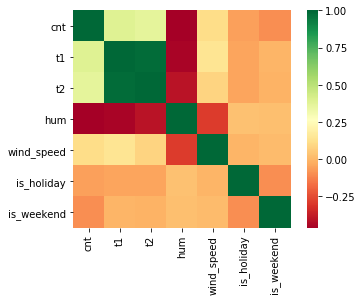

In [5]:
sns.heatmap(london_bikes.corr(), square=True, cmap='RdYlGn')

At first glance it seems t1, t2, hum, and wind_speed are the best predictors for cnt. I will be using the best_feature_ attribute of the future regression models to pull what each model deems the best predictor for the cnt target variable. But first, I will create a few scatter plots to look for outliers among (what I consider) the most important features as listed above. Then I will create some plots to compare the target variable for different bool values of the 'is_holiday' and 'is_weekend' columns.

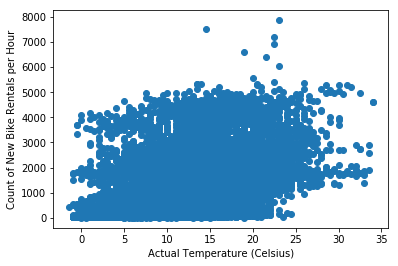

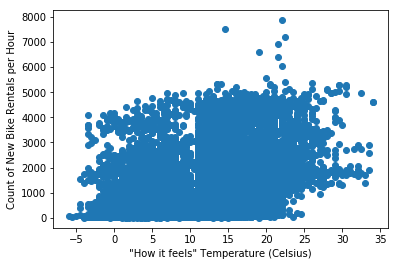

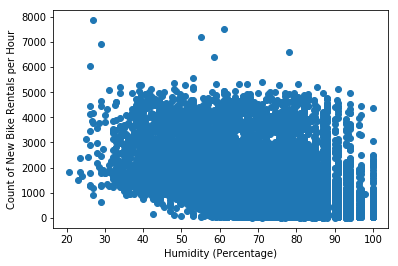

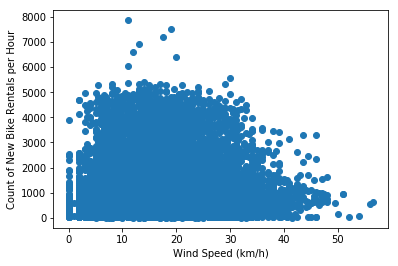

In [6]:
plt.scatter(london_bikes['t1'], london_bikes['cnt'])
plt.ylabel('Count of New Bike Rentals per Hour')
plt.xlabel('Actual Temperature (Celsius)')
plt.show()

plt.scatter(london_bikes['t2'], london_bikes['cnt']) #This will likely look just like the t1 plot
plt.ylabel('Count of New Bike Rentals per Hour')
plt.xlabel('"How it feels" Temperature (Celsius)')
plt.show()

plt.scatter(london_bikes['hum'], london_bikes['cnt'])
plt.ylabel('Count of New Bike Rentals per Hour')
plt.xlabel('Humidity (Percentage)')
plt.show()

plt.scatter(london_bikes['wind_speed'], london_bikes['cnt'])
plt.ylabel('Count of New Bike Rentals per Hour')
plt.xlabel('Wind Speed (km/h)')
plt.show()

In [3]:
#First I will create the separate DataFrames for the 'True' values in the 'is_holiday' and 'is_weekend' columns
yes_holiday_london_bikes = london_bikes[london_bikes['is_holiday'] == 1]
yes_holiday_london_bikes.info()
print(yes_holiday_london_bikes.head())

yes_weekend_london_bikes = london_bikes[london_bikes['is_weekend'] == 1]
yes_weekend_london_bikes.info()
print(yes_weekend_london_bikes.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 384 entries, 2015-04-03 00:00:00 to 2017-01-02 23:00:00
Data columns (total 9 columns):
cnt             384 non-null int64
t1              384 non-null float64
t2              384 non-null float64
hum             384 non-null float64
wind_speed      384 non-null float64
weather_code    384 non-null category
is_holiday      384 non-null bool
is_weekend      384 non-null bool
season          384 non-null category
dtypes: bool(2), category(2), float64(4), int64(1)
memory usage: 20.1 KB
                     cnt   t1   t2   hum  wind_speed weather_code  is_holiday  \
timestamp                                                                       
2015-04-03 00:00:00  279  8.0  6.0  82.0        10.0          7.0        True   
2015-04-03 01:00:00  174  8.0  5.5  79.0        14.0          7.0        True   
2015-04-03 02:00:00   89  7.5  5.5  84.5        12.0          7.0        True   
2015-04-03 03:00:00   61  7.0  5.0  87.0        11.0  

A good way to view all the data points and their distributions without viewing what looks like a large, thick cloud (as in the scatter plots above) is with an Empirical Cumulative Distribution Function (ECDF). The ECDF gives the viewer a good feel for the range of the data as well as where specifically the distributions lie for one feature. In this case, I will create three ECDFs showcasing the distributions of the target variables ('cnt') for the originial dataset, as well as for the recently created yes_holiday_london_bikes and yes_weekend_london_bikes DataFrames. First I will define a function that creates an ECDF after being fed a pandas Series.

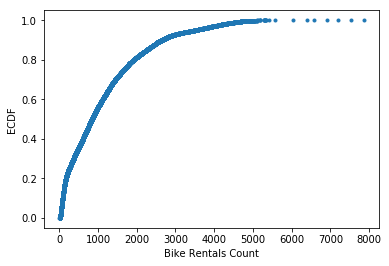

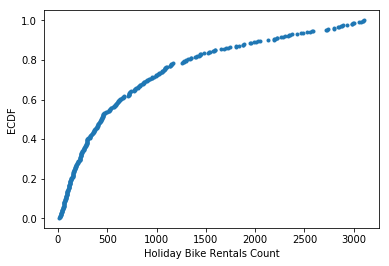

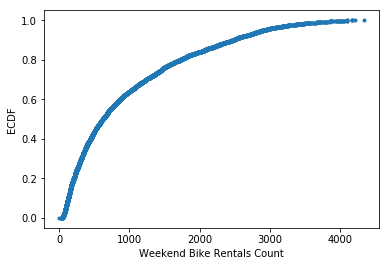

In [4]:
def ecdf(series):
    """Compute ECDF for a series of data"""
    points=len(series)
    x = np.sort(series)
    y = np.arange(1.0, points + 1.0) / points
    return x, y

x_all, y_all = ecdf(london_bikes['cnt'])
_ = plt.plot(x_all, y_all, marker='.', linestyle='none')
_ = plt.xlabel('Bike Rentals Count')
_ = plt.ylabel('ECDF')
plt.show()

x_holiday, y_holiday = ecdf(yes_holiday_london_bikes['cnt'])
_ = plt.plot(x_holiday, y_holiday, marker='.', linestyle='none')
_ = plt.xlabel('Holiday Bike Rentals Count')
_ = plt.ylabel('ECDF')
plt.show()

x_weekend, y_weekend = ecdf(yes_weekend_london_bikes['cnt'])
_ = plt.plot(x_weekend, y_weekend, marker='.', linestyle='none')
_ = plt.xlabel('Weekend Bike Rentals Count')
_ = plt.ylabel('ECDF')
plt.show()

I wasn't expecting the hours of highest rentals (>5000, only in the first ECDF plot) to occur on days that are neither holidays nor weekends. Perhaps the greatest usage of rental bikes comes from commuters on work days. I will now more closely examine these outliers to see what conditions the high rate of rental occurred under.

In [5]:
over_5000_cnt = london_bikes[london_bikes['cnt']>=5000]
print(over_5000_cnt)

                      cnt    t1    t2   hum  wind_speed weather_code  \
timestamp                                                              
2015-07-08 17:00:00  5560  20.0  20.0  53.0        30.0          2.0   
2015-07-09 07:00:00  5309  13.5  13.5  65.0        17.0          1.0   
2015-07-09 08:00:00  7531  14.5  14.5  61.0        19.0          2.0   
2015-07-09 16:00:00  6033  23.0  22.0  26.0        11.0          1.0   
2015-07-09 17:00:00  7860  23.0  22.0  27.0        11.0          1.0   
2015-07-09 18:00:00  6913  22.5  21.5  29.0        13.0          1.0   
2015-08-06 08:00:00  6585  19.0  19.0  78.0        12.0          7.0   
2015-08-06 16:00:00  5112  23.0  23.0  53.0        19.5          2.0   
2015-08-06 17:00:00  7208  22.5  22.5  55.0        17.5          2.0   
2015-08-06 18:00:00  6394  21.5  21.5  58.5        20.0          2.0   
2016-05-17 08:00:00  5322  13.5  13.5  59.0         8.0          1.0   
2016-07-06 08:00:00  5064  15.5  15.5  61.0        13.0         

All of these occurences are on Mon-Thurs, with times from 7-8am and 4-6pm, further supporting the notion that the high outliers of the target variable are caused by commuters going to and from work. I will create a scatter plot showing the target variable vs. hour of the day for weekdays to further investigate this phenomenon. I will first create a separate DataFrame containing only weekday entries from the london_bikes DF. Then I will create a new column 'hour' in the weekday_london_bikes DF drawn from the .hour attribute of the DatetimeIndex of weekday_london_bikes. I will then plot this 'hour' column in a scatter plot with the 'cnt' column to see how hour of day affects rentals on weekdays. My hypothesis is that larger values of 'cnt' will be seen at hour values of 7, 8, 16, 17, and 18; representing the "rush hour" hours of weekdays.

C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


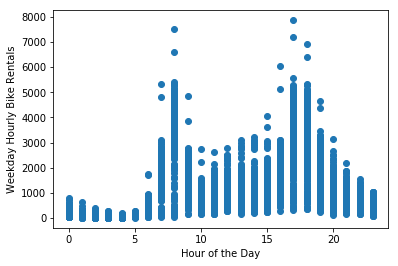

In [6]:
weekday_london_bikes = london_bikes[london_bikes['is_weekend'] == 0]
weekday_london_bikes['hour'] = weekday_london_bikes.index.hour
plt.scatter(weekday_london_bikes['hour'], weekday_london_bikes['cnt'])
plt.ylabel('Weekday Hourly Bike Rentals')
plt.xlabel('Hour of the Day')
plt.show()


As can be seen, not only are outliers shown at the hours predicted above, but consistently greater rentals occur frequently at the predicted hours than all other hours. I believe that the hour of day will consistently show up as the greatest predictive feature for each machine learning (ML) model I will be training. I do not currently know if the models can make the connection between DatetimeIndex and see that the hours within that index, without the date, are a great predictor of the target variable. To test whether or not they can, I will create a separate hour column within the london_bikes DF and compare the test statistic of interest between the hour column and DatetimeIndex.

But before I jump into that, there are trends to be found among the weather conditions that create ideal conditions that make people more open to bike sharing rather than their usual transportation mode. All outliers had weather codes 1.0 or 2.0 (with the exception of one 3.0 and one 7.0) representing clear days (1.0) or days with scattered clouds (2.0). I will now compare some feature scatter plots between the outliers and the original dataset.

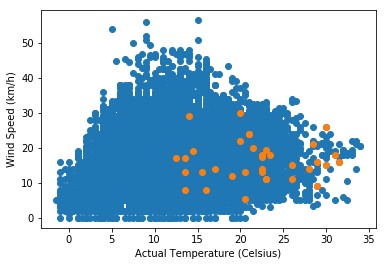

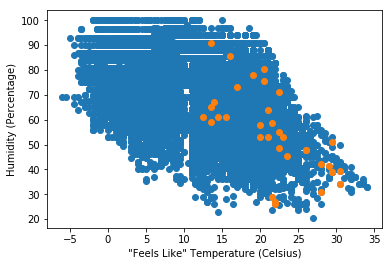

In [17]:
plt.scatter(london_bikes['t1'], london_bikes['wind_speed'])
plt.scatter(over_5000_cnt['t1'], over_5000_cnt['wind_speed'])
plt.ylabel('Wind Speed (km/h)')
plt.xlabel('Actual Temperature (Celsius)')
plt.show()

plt.scatter(london_bikes['t2'], london_bikes['hum'])
plt.scatter(over_5000_cnt['t2'], over_5000_cnt['hum'])
plt.ylabel('Humidity (Percentage)')
plt.xlabel('"Feels Like" Temperature (Celsius)')
plt.show()

It is easy to see how a regressor could fit a line to the outlier points among these features. I will use the least squares method, finding the parameters for which the sum of the squares of the residuals (the vertical distance between the line and an individual data point, negative if the point is below the line) is minimal. I will use the numpy function polyfit() which uses polynomial functions to perform least squares analysis. The parameters I will give are the x and y data (in this case t1 and wind_speed for the first plot, and t2 and hum for the second plot) as well as the degree of the polynomial function I wish to fit (in this case 1, as I wish for a linear plot). I will also plot a line for the original dataset to compare.

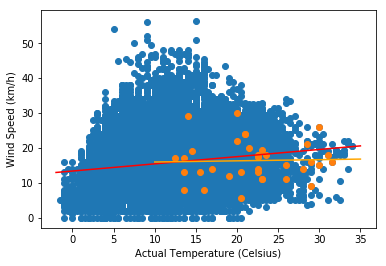

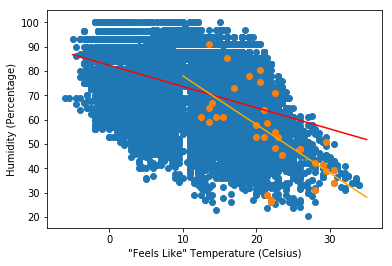

In [16]:
a1, b1 = np.polyfit(london_bikes['t1'], london_bikes['wind_speed'], 1)
x1 = np.array([-2, 35])
y1 = a1 * x1 + b1
plt.plot(x1, y1, c = 'red')
a2, b2 = np.polyfit(over_5000_cnt['t1'], over_5000_cnt['wind_speed'], 1)
x2 = np.array([10, 35])
y2 = a2 * x2 + b2
plt.plot(x2, y2, c = 'orange')
plt.scatter(london_bikes['t1'], london_bikes['wind_speed'])
plt.scatter(over_5000_cnt['t1'], over_5000_cnt['wind_speed'])
plt.ylabel('Wind Speed (km/h)')
plt.xlabel('Actual Temperature (Celsius)')
plt.show()

a3, b3 = np.polyfit(london_bikes['t2'], london_bikes['hum'], 1)
x3 = np.array([-5, 35])
y3 = a3 * x3 + b3
plt.plot(x3, y3, c = 'red')
a4, b4 = np.polyfit(over_5000_cnt['t2'], over_5000_cnt['hum'], 1)
x4 = np.array([10, 35])
y4 = a4 * x4 + b4
plt.plot(x4, y4, c = 'orange')
plt.scatter(london_bikes['t2'], london_bikes['hum'])
plt.scatter(over_5000_cnt['t2'], over_5000_cnt['hum'])
plt.ylabel('Humidity (Percentage)')
plt.xlabel('"Feels Like" Temperature (Celsius)')
plt.show()

Now, time for the real predictions.

First, I will split the data into train and test sets. This involves choosing a percentage of the total data on which to train my models and a (usually much smaller) percentage to act as unseen data to test the model's effectiveness upon. Typically, the split is 70-30 or 80-20. I will be using an 80% training set and 20% test set.
I will use these datasets to compare the effectiveness of an individual CART vs. ensemble methods: Random Forests vs. Adaptive Boosting vs. Gradient Boosting, expanding upon the specifics of each method as they come along. 

Decision trees (or CARTs) are flowchart-like structure in which each internal node (where a decision is made) represents a test or dividing based on a feature's value. Each branch forming off the node represents one of two possible outcomes resulting from a decision boundary. The end nodes (also called leaf nodes or leafs) have no branches and represent class labels. In regression problems, the target variable is calculated as teh average of the target variables within the leaf. In general, CARTs are able to capture non-linear realtionships between features and labels, as compared to linear models. In additions, CARTs do not require the features to be on the same scale. However, CARTs can be very sensitive to small variations within the training set and can also suffer from high variance when they are trained without constraints. Ensemble learning can take advantage of the flexibility of CARTs while reducing their tendency to memorize noise. 

In ensemble learning, different models are trained on the same dataset. Each model then makes its own predictions. A meta-model then aggregates those predictions and outputs a final prediction. The final prediction is more robust and less prone to errors than each individual model's predictions.

Now for the first ML model: the decision tree regressor. Because sklearn ML models cannot accept Datetime64 type data, I will be breaking down the DatetimeIndex into separate columns of year, month, day of the week, and hour. Later when I convert the DF into X and y before train_test_split I will not need include the index and therefore will not need to remove or delete the index beforehand. Then I will perform train_test_split and set a SEED parameter for the random_state to allow for reproducability.

In [7]:
london_bikes['year'] = london_bikes.index.year
london_bikes['month'] = london_bikes.index.month
london_bikes['day'] = london_bikes.index.weekday
london_bikes['hour'] = london_bikes.index.hour
london_bikes = london_bikes.astype({'year':'category', 'month':'category',
                                      'day':'category', 'hour':'category'})
print(london_bikes.head())
print(london_bikes.info())

                     cnt   t1   t2    hum  wind_speed weather_code  \
timestamp                                                            
2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0          3.0   
2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0          1.0   
2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0          1.0   
2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0          1.0   
2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5          1.0   

                     is_holiday  is_weekend season  year month day hour  
timestamp                                                                
2015-01-04 00:00:00       False        True    3.0  2015     1   6    0  
2015-01-04 01:00:00       False        True    3.0  2015     1   6    1  
2015-01-04 02:00:00       False        True    3.0  2015     1   6    2  
2015-01-04 03:00:00       False        True    3.0  2015     1   6    3  
2015-01-04 04:00:00       False        True    3.0  2015     1   

In [8]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score
SEED = 14
y = london_bikes['cnt'].values.reshape(-1, 1)
X = london_bikes.drop(['cnt'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
dt1 = DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 0.05, random_state = SEED) #the parameter max_depth specifies
#the number of branches from the top (beginning) of the tree to the bottom node (end). The parameter min_samples_leaf imposes
#a condition in which each leaf (end node) has to contain at least the specified ratio of the fed data.
dt1.fit(X_train, y_train)
y_pred = dt1.predict(X_test)
print('Test set r2 of dt: {:.3f}'.format(dt1.score(X_test, y_test)))

columns = list(london_bikes.columns.values)
columns.remove('cnt')
importances1 = dt1.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(importances1[n]))

Test set r2 of dt: 0.572
t1 importance: 0.011749266924266949
t2 importance: 0.09918875577632778
hum importance: 0.0
wind_speed importance: 0.0
weather_code importance: 0.0
is_holiday importance: 0.0
is_weekend importance: 0.044671191927217316
season importance: 0.0
year importance: 0.0
month importance: 0.0
day importance: 0.0021270386097273415
hour importance: 0.8422637467624606


Now that the model is instantiated, I wish to make sure that the generalization error (a measurement of how the model will perform on unseen data) is within reason. This estimate cannot be performed directly as the "perfect" model is unknown, we only have one dataset to train and test upon, and I do not have access to an error approximation to estimate the error due to noise. The error can be approximated upon the test set, but a better model evaluation can be performed before touching the test set. This is done using cross-validation (CV). CV splits the training set into a specified number of groups, trains on the number of groups minus one and then evaluates on the last group. The group being evaluated upon changes with each computation. One can then compare the calculated summary statistic for each fold to get a better idea of the model's generalization error without a training-test split bias. It reduces dependency upon an essentially random split from the train_test_split function.

I will be comparing the CV scores of the R squared (r2) value to the r2 value of the trained model upon the test set. The comparison of these metrics can tell me about whether the model is overfitted or underfitted to the training set. If either overfitting or underfitting occur, I can make changes to the hyperparameters of the model dt.

As predicted above after viewing the over_5000_cnt DF, the hour of day is shown to be the most highly predictive feature by far. Only four of the features had any predictive value at all according to the DecisionTreeRegressor, with 'day' blowing the other three out of the water. I look forward to seeing if any of the ensemble methods include features not included in this model. I do predict that 'hour' will remain the strongest feature throughout the models' performances.

Feature selection is one of the most important aspects of training ML models. Irrelevant or low relevance features can negatively impact the performance of ML models. Having irrelevant features can impact the accuracy of models and make models learn based on features that do not correspond to the target variable. Using only the most relevant features can improve model performance as well as reduce overfitting (by removing noise) and reduce algorithm training time. As I tune the decision tree models, I will be taking care to note the most relevant features as denoted by the feature_importance_ attribute of each CART. I can then use only the most relevant features to ensure peak model performance (whether CART or ensemble).

In [9]:
r_squared_CV_scores1 = cross_val_score(dt1, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1) #the n_jobs parameter
#to -1 maximizes computer usage.
print(r_squared_CV_scores1)

[0.55449597 0.53854184 0.55946512 0.56587051 0.57625457]


Because the performance of the model upon the test set is quite close to the performance of the CV trials, and both are less than the desired performance, it seems the model is underfitted to the training set, suffering from high bias. I will be increasing model complexity to see if performance can be improved. 

In [39]:
dt2 = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 0.05, random_state = SEED) #increased max_depth parameter
#to 5.
dt2.fit(X_train, y_train)
y_pred = dt2.predict(X_test)
print('Test set r2 of dt: {:.3f}'.format(dt2.score(X_test, y_test)))
importances2 = dt2.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(importances2[n]))

Test set r2 of dt: 0.645
t1 importance: 0.08839603553360928
t2 importance: 0.010470830170240215
hum importance: 0.015463717727597474
wind_speed importance: 0.0
weather_code importance: 0.0
is_holiday importance: 0.0
is_weekend importance: 0.04170611897564577
season importance: 0.0
year importance: 0.0
month importance: 0.0
day importance: 0.0
hour importance: 0.8439632975929073


In [41]:
r_squared_CV_scores2 = cross_val_score(dt2, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print(r_squared_CV_scores2)

[0.64184422 0.60397541 0.61696115 0.64143778 0.64791274]


Just as predicted, increasing the complexity of the model (in this case, increasing the number of branches) increased model performance! Also, as model complexity increased, in this case 'hum' was added to the used features. Let me see if further increases in complexity will give greater results and maybe add another feature to the model's calculations.

In [40]:
dt3 = DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 0.05, random_state = SEED) #increased max_depth parameter
#to 6.
dt3.fit(X_train, y_train)
y_pred = dt3.predict(X_test)
print('Test set r2 of dt: {:.3f}'.format(dt3.score(X_test, y_test)))
importances3 = dt3.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(importances3[n]))

Test set r2 of dt: 0.691
t1 importance: 0.0829062216170677
t2 importance: 0.009820541853130424
hum importance: 0.014503347364040187
wind_speed importance: 0.0
weather_code importance: 0.0
is_holiday importance: 0.0
is_weekend importance: 0.0
season importance: 0.0
year importance: 0.0
month importance: 0.0
day importance: 0.03911597077527331
hour importance: 0.8536539183904884


In [42]:
r_squared_CV_scores3 = cross_val_score(dt3, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print(r_squared_CV_scores3)

[0.68855168 0.65092376 0.67165208 0.67929064 0.69389198]


In [27]:
dt4 = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 0.05, random_state = SEED) #increased max_depth parameter
#to 7.
dt4.fit(X_train, y_train)
y_pred = dt4.predict(X_test)
print('Test set r2 of dt: {:.3f}'.format(dt4.score(X_test, y_test)))
importances4 = dt4.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(importances4[n]))

Test set r2 of dt: 0.692
t1 importance: 0.009795550739240502
t2 importance: 0.08269524356131464
hum importance: 0.014466439542539048
wind_speed importance: 0.0
weather_code importance: 0.0
is_holiday importance: 0.0
is_weekend importance: 0.0372430833281719
season importance: 0.0
year importance: 0.0
month importance: 0.0025447795308721974
day importance: 0.0017733459253422915
hour importance: 0.8514815573725194


In [45]:
r_squared_CV_scores4 = cross_val_score(dt4, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print(r_squared_CV_scores4)

[0.69037408 0.65273712 0.67359844 0.68060533 0.69639647]


dt4 only performed marginally better than dt3. Both the models' performances upon the test set is greater than that of the average of the CV performances. In addition, now 'day' (and 'month' for dt4) was a feature used in calculating the target variable. Looking at the feature importances from the last four models, I think a better training set can be obtained in just using 't1', 'hum', 'day', and (of course) 'hour'. I will see if I get better results using the same parameters as d4 with a different, more focused, X_train.

In [10]:
X2 = london_bikes.drop(['cnt', 't2', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season',
                       'year', 'month'], axis=1).values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.2, random_state = SEED)

In [11]:
dt5 = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 0.05, random_state = SEED) #same parameters as dt4
dt5.fit(X2_train, y2_train)
y_pred = dt5.predict(X2_test)
print('Test set r2 of 4-feature dt: {:.3f}'.format(dt5.score(X2_test, y2_test)))
importances5 = dt5.feature_importances_
columns2 = ['t1', 'hum', 'day', 'hour']
for n in range(len(columns2)):
    print(columns2[n] + ' importance: ' + str(importances5[n]))

Test set r2 of 4-feature dt: 0.692
t1 importance: 0.0946785307840493
hum importance: 0.014472147105742218
day importance: 0.039031822725783004
hour importance: 0.8518174993844254


In [12]:
r_squared_CV_scores5 = cross_val_score(dt5, X2_train, y2_train, cv = 5, scoring = 'r2', n_jobs = -1)
print(r_squared_CV_scores5)

[0.6911138  0.65206501 0.67359844 0.68009677 0.69649862]


I achieved the same r2 value using 1/3 the previous amount of features! (from 12 to 4). I believe the removal of noise will have a greater effect on the ensemble models than on the CART.

Now that I have obtained a performance score from a (semi-) optimized model, I will now test ensemble methods to see if I can get a greater r2 score, proving a superior regression method. 

I will begin with Random Forests (RF), an ensemble method that uses only decision trees as its base estimator. Each estimator is trained on a different bootstrap sample with the same size as the training set. A bootstrap sample randomly picks entries from the feature data, sampling with replacement. Furthermore, at each node a number d of features are sampled without replacement, where d is less than the total number of features (in this case, 12). Typically, d defaults to the square root of the total number of features. Each node within each tree is split using the sampled feature that maximizes information gain. Once the ensemble is trained and a new instance fed to the ensemble, each base estimator makes a prediction and (for regression) each estimator's predictions are aggregated through averaging.

In general, RF achieves a lower variance than individual CARTs.

In [28]:
rf = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 0.12, max_features = 'sqrt', random_state = SEED)
rf.fit(X_train, y_train)
print('Test set r2 of rf: {:.3f}'.format(rf.score(X_test, y_test)))
rf_importances = rf.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(rf_importances[n]))
rf_r_squared_CV_scores = cross_val_score(rf, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('RF r2 CV scores: ')
print(rf_r_squared_CV_scores)
    
rf.fit(X2_train, y2_train)
print('Test set r2 of 4-feature rf: {:.3f}'.format(rf.score(X2_test, y2_test)))
rf_importances = rf.feature_importances_
for n in range(len(columns2)):
    print(columns2[n] + ' importance: ' + str(rf_importances[n]))
rf_r_squared_CV_scores = cross_val_score(rf, X2_train, y2_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('4-feature RF r2 CV scores: ')
print(rf_r_squared_CV_scores)

C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Test set r2 of rf: 0.379
t1 importance: 0.10728058638829346
t2 importance: 0.15275883229359544
hum importance: 0.21965686523225794
wind_speed importance: 0.00888510871235909
weather_code importance: 0.04278002722760142
is_holiday importance: 0.0
is_weekend importance: 0.0050085459725296684
season importance: 0.025421834289024923
year importance: 0.00032369174426154766
month importance: 0.012781836741404994
day importance: 0.013459940666211043
hour importance: 0.41164273073246044
RF r2 CV scores: 
[0.36969858 0.3632038  0.3743128  0.37395266 0.37722376]


C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Test set r2 of 4-feature rf: 0.455
t1 importance: 0.12776834413280377
hum importance: 0.2454612629769765
day importance: 0.007450955348516765
hour importance: 0.6193194375417028


The RF model achieves worse results than the individual CARTs. I believe this is due to a large portion of the models making up the ensemble not including the 'hour' column, when the 'hour' column has been shown to be the greatest predictive feature of the target variable. I will create another RF model using all features and see what r2 score, importances, and CV scores I come up with.

In [29]:
rf2 = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 0.12, random_state = SEED)#The default value for max_features
#is 'auto' which is n_features (the total number of features available).
rf2.fit(X_train, y_train)
print('Test set r2 of rf2: {:.3f}'.format(rf2.score(X_test, y_test)))
rf2_importances = rf2.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(rf2_importances[n]))
rf2_r_squared_CV_scores = cross_val_score(rf2, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('RF2 r2 CV scores: ')
print(rf2_r_squared_CV_scores)
    
rf2.fit(X2_train, y2_train)
print('Test set r2 of 4-feature rf2: {:.3f}'.format(rf2.score(X2_test, y2_test)))
rf2_importances = rf2.feature_importances_
for n in range(len(columns2)):
    print(columns2[n] + ' importance: ' + str(rf2_importances[n]))
rf2_r_squared_CV_scores = cross_val_score(rf2, X2_train, y2_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('4-feature RF2 r2 CV scores: ')
print(rf2_r_squared_CV_scores)

C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Test set r2 of rf2: 0.468
t1 importance: 0.04629985160430996
t2 importance: 0.05452346258070514
hum importance: 0.0
wind_speed importance: 0.0
weather_code importance: 0.0
is_holiday importance: 0.0
is_weekend importance: 0.0
season importance: 0.0
year importance: 0.0
month importance: 0.0
day importance: 0.0
hour importance: 0.899176685814985
RF2 r2 CV scores: 
[0.44223158 0.45228629 0.46430462 0.45393053 0.45845538]


C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Test set r2 of 4-feature rf2: 0.468
t1 importance: 0.10082331418501506
hum importance: 0.0
day importance: 0.0
hour importance: 0.899176685814985
4-feature RF2 r2 CV scores: 
[0.44162528 0.45228629 0.46389281 0.45393053 0.45845538]


Once more the RF model achieves worse results than individual CARTs. I saw vast improvement in the CARTs when increasing the maximum_depth parameter; let me see if the same change will give a similar increase in effectiveness with this ensemble model.

In [30]:
rf3 = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 0.05, max_depth = 7, random_state = SEED) #A change
#in the max_depth parameter requires a change in the min_samples_leaf parameter.
rf3.fit(X_train, y_train)
print('Test set r2 of rf3: {:.3f}'.format(rf3.score(X_test, y_test)))
rf3_importances = rf3.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(rf3_importances[n]))
rf3_r_squared_CV_scores = cross_val_score(rf3, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('RF3 r2 CV scores: ')
print(rf3_r_squared_CV_scores)
    
rf3.fit(X2_train, y2_train)
print('Test set r2 of 4-feature rf3: {:.3f}'.format(rf3.score(X2_test, y2_test)))
rf3_importances = rf3.feature_importances_
for n in range(len(columns2)):
    print(columns2[n] + ' importance: ' + str(rf3_importances[n]))
rf3_r_squared_CV_scores = cross_val_score(rf3, X2_train, y2_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('4-feature RF3 r2 CV scores: ')
print(rf3_r_squared_CV_scores)

C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Test set r2 of rf3: 0.632
t1 importance: 0.050678958165065395
t2 importance: 0.05429713525989952
hum importance: 0.0035305072254786522
wind_speed importance: 0.0
weather_code importance: 0.0001305243712924332
is_holiday importance: 0.0
is_weekend importance: 0.019509334737202205
season importance: 0.00016808859646221314
year importance: 0.0
month importance: 1.5028955163555206e-06
day importance: 0.022981861361605203
hour importance: 0.8487020873874777
RF3 r2 CV scores: 
[0.60441582 0.58376635 0.6333584  0.61271996 0.64225051]


C:\Users\Melissa\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Test set r2 of 4-feature rf3: 0.632
t1 importance: 0.10523522969297153
hum importance: 0.0035306173413136377
day importance: 0.04249165380725714
hour importance: 0.8487424991584573
4-feature RF3 r2 CV scores: 
[0.60444483 0.58371771 0.633329   0.61259941 0.64212366]


This ensemble is much closer to the effectiveness of the best CART I trained above, though the r2 value is not as high. Perhaps one of the other ensemble methods will prove more effective.

For rf2 and rf3, the removal of the less relevant features did not affect the r2 score. 

The next ensemble method to train is the Adaptive Boosting (AdaBoost) model. Boosting refers to an ensemble method in which many estimators are trained and each estimator learns from the errors of the previous estimator in the ensemble. Essentially, many weak learners are combined to form a strong learner. A weak learner is defined as an estimator that performs slightly better than random guessing. For example, a decision tree with a max depth of 1 (also called a decision stump) is considered a weak learner.

In AdaBoost specifically, each estimator in the ensemble pays closer attention to the instances wrongly predicted by previous estimators by constantly changing the weights of the training instances. Each estimator is also assigned a coefficient α (alpha) that weighs the estimator's contribution in the ensemble's final prediction. α depends on the estimator's training error.

In [31]:
dt_ada = DecisionTreeRegressor(max_depth = 3, random_state = SEED)
adb_reg = AdaBoostRegressor(base_estimator = dt_ada, n_estimators = 50, random_state = SEED)
adb_reg.fit(X_train, y_train)
print('Test set r2 of adb_reg: {:.3f}'.format(adb_reg.score(X_test, y_test)))
adb_reg_importances = adb_reg.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(adb_reg_importances[n]))
adb_r_squared_CV_scores = cross_val_score(adb_reg, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('AdaBoost r2 CV scores: ')
print(adb_r_squared_CV_scores)
    
adb_reg.fit(X2_train, y2_train)
print('Test set r2 of 4-feature adb_reg: {:.3f}'.format(adb_reg.score(X2_test, y2_test)))
adb_reg_importances = adb_reg.feature_importances_
for n in range(len(columns2)):
    print(columns2[n] + ' importance: ' + str(adb_reg_importances[n]))
adb_r_squared_CV_scores = cross_val_score(adb_reg, X2_train, y2_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('4-feature AdaBoost r2 CV scores: ')
print(adb_r_squared_CV_scores)    

C:\Users\Melissa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set r2 of adb_reg: 0.338
t1 importance: 0.09065269631663542
t2 importance: 0.06309528394438771
hum importance: 0.2061511237656143
wind_speed importance: 0.06049263366203045
weather_code importance: 0.014569430991681766
is_holiday importance: 0.005824521639316169
is_weekend importance: 0.00918703951358531
season importance: 0.01108915743338062
year importance: 0.008152555221860766
month importance: 0.02219581648590561
day importance: 0.11717587915548126
hour importance: 0.3914138618701208
AdaBoost r2 CV scores: 
[0.45569342 0.45904347 0.45399768 0.37347284 0.39517236]


C:\Users\Melissa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set r2 of 4-feature adb_reg: 0.480
t1 importance: 0.21526187947678083
hum importance: 0.22537001948855345
day importance: 0.14124444218993243
hour importance: 0.4181236588447333
4-feature AdaBoost r2 CV scores: 
[0.46799261 0.49657235 0.56508328 0.42888339 0.53643115]


Let me see if, like the CART and RF models above, increasing the max_depth results in a more effective predictor. The CV scores, on average, are higher than the r2 scores of the AdaBoost models on the test set. This indicates an increase in model complexity could result in a more accurate model.

In [32]:
dt_ada2 = DecisionTreeRegressor(max_depth = 6, random_state = SEED)
adb_reg2 = AdaBoostRegressor(base_estimator = dt_ada2, n_estimators = 50, random_state = SEED)
adb_reg2.fit(X_train, y_train)
print('Test set r2 of adb_reg2: {:.3f}'.format(adb_reg2.score(X_test, y_test)))
adb_reg2_importances = adb_reg2.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(adb_reg2_importances[n]))
adb2_r_squared_CV_scores = cross_val_score(adb_reg2, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('AdaBoost2 r2 CV scores: ')
print(adb2_r_squared_CV_scores)
    
adb_reg2.fit(X2_train, y2_train)
print('Test set r2 of 4-feature adb_reg: {:.3f}'.format(adb_reg2.score(X2_test, y2_test)))
adb_reg2_importances = adb_reg2.feature_importances_
for n in range(len(columns2)):
    print(columns2[n] + ' importance: ' + str(adb_reg2_importances[n]))
adb2_r_squared_CV_scores = cross_val_score(adb_reg2, X2_train, y2_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('4-feature AdaBoost2 r2 CV scores: ')
print(adb2_r_squared_CV_scores) 

C:\Users\Melissa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set r2 of adb_reg2: 0.884
t1 importance: 0.07085317774825983
t2 importance: 0.09715425090424462
hum importance: 0.15204920309073805
wind_speed importance: 0.042434730030432286
weather_code importance: 0.02562425217325718
is_holiday importance: 0.032239297357072
is_weekend importance: 0.02238025216258084
season importance: 0.03612311022890699
year importance: 0.018428181007034163
month importance: 0.03788935008162956
day importance: 0.10299268094129205
hour importance: 0.3618315142745522
AdaBoost2 r2 CV scores: 
[0.84518969 0.87131793 0.85864433 0.86187142 0.8433018 ]


C:\Users\Melissa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set r2 of 4-feature adb_reg: 0.805
t1 importance: 0.31126142917587113
hum importance: 0.20750192428933195
day importance: 0.15850169627496727
hour importance: 0.3227349502598298
4-feature AdaBoost2 r2 CV scores: 
[0.77004812 0.78881315 0.80442049 0.78991148 0.78628109]


Wow! This is by far the most effective model yet. It seems that for AdaBoost that having more features gives better results. The CV scores being slightly below the test set scores indicates that the model is quite optimized as far as complexity is concerned.

Now for Gradient Boosting (GB). GB is a very popular boosting algorithm and has been used to win many ML competitions. Like AdaBoost, each estimator in GB fixes its predecessor's error. In contrast to AdaBoost, the weights of the training instances are not tweaked between each estimator. Instead, each estimator is trained using the residual errors of its predecessor as labels. Also, gradient boosting only uses CARTs as its estimators.

In [33]:
gb = GradientBoostingRegressor(n_estimators = 300, max_depth = 2, random_state = SEED)
gb.fit(X_train, y_train)
print('Test set r2 of gb: {:.3f}'.format(gb.score(X_test, y_test)))
gb_importances = gb.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(gb_importances[n]))
gb_r_squared_CV_scores = cross_val_score(gb, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('GB r2 CV scores: ')
print(gb_r_squared_CV_scores)
    
gb.fit(X2_train, y2_train)
print('Test set r2 of 4-feature gb: {:.3f}'.format(gb.score(X2_test, y2_test)))
gb_importances = gb.feature_importances_
for n in range(len(columns2)):
    print(columns2[n] + ' importance: ' + str(gb_importances[n]))
gb_r_squared_CV_scores = cross_val_score(gb, X2_train, y2_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('4-feature GB r2 CV scores: ')
print(gb_r_squared_CV_scores) 

C:\Users\Melissa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set r2 of gb: 0.823
t1 importance: 0.05985233904448207
t2 importance: 0.03295721299195878
hum importance: 0.07281194249887636
wind_speed importance: 0.00269632706679835
weather_code importance: 0.017330937775868548
is_holiday importance: 0.002653296887997914
is_weekend importance: 0.047386442983331445
season importance: 0.006615218828223978
year importance: 0.0013324620983717111
month importance: 0.0034694440432731003
day importance: 0.04451967586407648
hour importance: 0.7083746999167412
GB r2 CV scores: 
[0.79557666 0.81902027 0.81390596 0.81329574 0.79546332]


C:\Users\Melissa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set r2 of 4-feature gb: 0.844
t1 importance: 0.09611751934955681
hum importance: 0.07908187363861324
day importance: 0.1380017630194134
hour importance: 0.6867988439924164
4-feature GB r2 CV scores: 
[0.81826538 0.83068617 0.83165045 0.82736406 0.81744983]


No wonder GB wins ML competitions! The results seen here blow the CARTs and RF out of the water! Additionally, the removal of less relevant features gave an even greater performance score. However, the second iteration of the AdaBoost model had a higher r2 value. Perhaps I can squeeze additional functionality out of the GB model by changing the max_depth. 

In [34]:
gb2 = GradientBoostingRegressor(n_estimators = 300, max_depth = 3, random_state = SEED)
gb2.fit(X_train, y_train)
print('Test set r2 of gb: {:.3f}'.format(gb2.score(X_test, y_test)))
gb2_importances = gb2.feature_importances_
for n in range(len(columns)):
    print(columns[n] + ' importance: ' + str(gb2_importances[n]))
gb2_r_squared_CV_scores = cross_val_score(gb2, X_train, y_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('GB2 r2 CV scores: ')
print(gb2_r_squared_CV_scores)
    
gb2.fit(X2_train, y2_train)
print('Test set r2 of 4-feature gb: {:.3f}'.format(gb2.score(X2_test, y2_test)))
gb2_importances = gb2.feature_importances_
for n in range(len(columns2)):
    print(columns2[n] + ' importance: ' + str(gb2_importances[n]))
gb2_r_squared_CV_scores = cross_val_score(gb2, X2_train, y2_train, cv = 5, scoring = 'r2', n_jobs = -1)
print('4-feature GB2 r2 CV scores: ')
print(gb2_r_squared_CV_scores) 

C:\Users\Melissa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set r2 of gb: 0.939
t1 importance: 0.026298037125599038
t2 importance: 0.05141018846863991
hum importance: 0.0506046472161376
wind_speed importance: 0.0026409267341131397
weather_code importance: 0.014801244202506995
is_holiday importance: 0.004825579803659659
is_weekend importance: 0.0812445528098288
season importance: 0.004604100615600957
year importance: 0.0013092775473996178
month importance: 0.0035038022092273445
day importance: 0.05116605709145685
hour importance: 0.7075915861758302
GB2 r2 CV scores: 
[0.92721194 0.93350715 0.93522177 0.93892316 0.92056335]


C:\Users\Melissa\Anaconda2\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Test set r2 of 4-feature gb: 0.917
t1 importance: 0.08483533870020823
hum importance: 0.058229886571904914
day importance: 0.14630994500540068
hour importance: 0.7106248297224862
4-feature GB2 r2 CV scores: 
[0.90295389 0.90268125 0.89956483 0.91390763 0.89418104]


Best results yet! Looking at how the CARTs performed, I never would have imagined one of these models achieving an r2 score > 0.90. And the CV r2 scores tell me that the results are not a result of overfitting the data. It is also interesting to see as the GB models' complexity increased, more features led to better results.

To conclude this study, it seems that Gradient Boosted Regression Trees resulted in the best predictor for rental counts of this dataset. In general, boosted ensemble models performed much better than individual CARTs or RandomForest ensembles. As ensemble models' complexity increased, more features led to greater results, even if many of those features seemed to have low importance scores.